In [36]:
import tensorflow as tf

In [37]:
import os

In [38]:
import random
import numpy as np

In [39]:
from tqdm import tqdm

In [40]:
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [41]:
Train_path = 'Unet/stage1_train/'
Test_path = 'Unet/stage1_test/'

In [44]:
len(Test_path)

17

In [45]:
train_ids = next(os.walk(Train_path))[1]
test_ids = next(os.walk(Test_path))[1]

In [47]:
X_train = np.zeros((len(train_ids), Img_height, Img_width, Img_channels), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), Img_height, Img_width, 1), dtype = np.bool)

In [50]:
# Train Images

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = Train_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :Img_channels]
    img = resize(img, (Img_height, Img_width), mode = 'constant', preserve_range = True)
    X_train[n] = img  ### Fill empty X_train with values from img
    mask = np.zeros((Img_height, Img_width, 1), dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (Img_height, Img_width), mode = 'constant', preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_)
        
    Y_train[n] = mask

  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [13:05<00:00,  1.17s/it]


In [63]:
# Test Images

X_test = np.zeros((len(test_ids), Img_height, Img_width, Img_channels), dtype = np.uint8)
sizes_test = []
print('resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = Test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :Img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (Img_height, Img_width), mode = 'constant', preserve_range = True)
    X_test[n] = img
    
print('done!')

  8%|██████▍                                                                            | 5/65 [00:00<00:01, 47.74it/s]

resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 34.47it/s]

done!


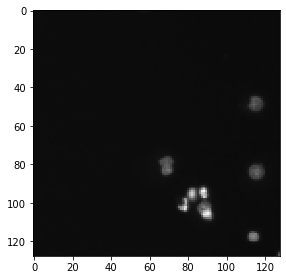

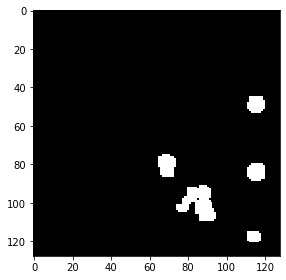

In [65]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [54]:
Img_width = 128
Img_height = 128
Img_channels = 3

#### Model Building

## UNET

In [66]:
### Contractive path

inputs = tf.keras.layers.Input((Img_width, Img_height, Img_channels))

s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)


### Expansive Path

u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)



### MODEL

model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_16 (Lambda)             (None, 128, 128, 3)  0           ['input_17[0][0]']               
                                                                                                  
 conv2d_184 (Conv2D)            (None, 128, 128, 16  448         ['lambda_16[0][0]']              
                                )                                                                 
                                                                                            

In [67]:
### Model Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_segmentation.hy', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]

In [68]:
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size = 16, epochs = 5, callbacks=callbacks)

Epoch 1/5
36/36 [==============================] - 67s 2s/step - loss: 0.5494 - accuracy: 0.7860 - val_loss: 0.3787 - val_accuracy: 0.8085
Epoch 2/5
36/36 [==============================] - 66s 2s/step - loss: 0.3022 - accuracy: 0.8244 - val_loss: 0.2170 - val_accuracy: 0.9044
Epoch 3/5
36/36 [==============================] - 73s 2s/step - loss: 0.2121 - accuracy: 0.9184 - val_loss: 0.1708 - val_accuracy: 0.9384
Epoch 4/5
36/36 [==============================] - 62s 2s/step - loss: 0.1573 - accuracy: 0.9444 - val_loss: 0.1479 - val_accuracy: 0.9479
Epoch 5/5
36/36 [==============================] - 55s 2s/step - loss: 0.1383 - accuracy: 0.9517 - val_loss: 0.1281 - val_accuracy: 0.9520


#### Predictions/Results

In [69]:
idx = random.randint(0, len(X_train))

In [70]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 234ms/step


In [71]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

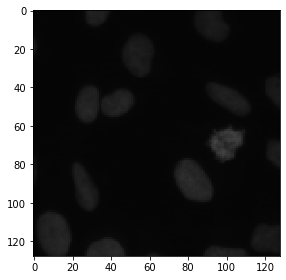

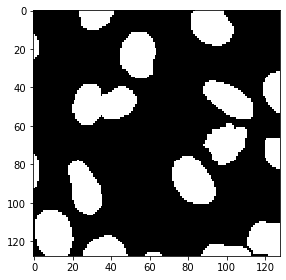

C:\Users\Md Zishan Ansari\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


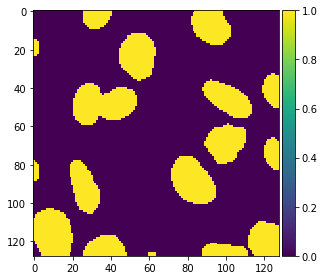

In [74]:
# Perform sanity check on some training samples

ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

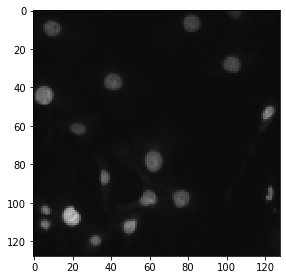

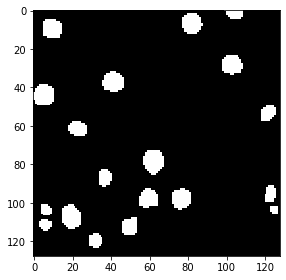

C:\Users\Md Zishan Ansari\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


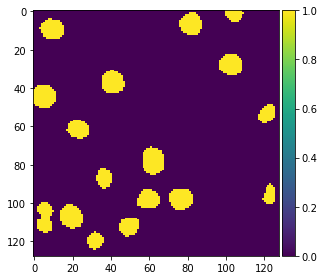

In [76]:
# Perform a sanity check on some Validation samples


ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()